## Setup and imports

In [1]:
%pip install pyarrow

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import json
from pathlib import Path
import pickle
import time

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as sp 
import seaborn as sns

%matplotlib inline

DATA_DIR = Path('./data')


In [5]:
# input
CORE_DF_PATH = DATA_DIR / 'core_df.feather'
DISR_DF_PATH = DATA_DIR / 'disruption_df.feather'
NOVELTY_JSONS = list((DATA_DIR / 'shibayama').glob('bare*.json'))
ANALYSIS_DF_PATH = DATA_DIR / 'analysis_df.feather'

[PosixPath('data/shibayama/bare_result_3.json'),
 PosixPath('data/shibayama/bare_result_5.json'),
 PosixPath('data/shibayama/bare_result_1.json'),
 PosixPath('data/shibayama/bare_result_0.json'),
 PosixPath('data/shibayama/bare_result_4.json')]

# Build Analysis DataFrame

In [52]:
core_df = pd.read_feather(CORE_DF_PATH).set_index('id').sort_index()
disr_raw = pd.read_feather(DISR_DF_PATH).set_index('id').sort_index()

novelty = {}
novelty_ids = []
for path in NOVELTY_JSONS:
    with path.open('rb') as infile:
        novelty_chunk = json.load(infile)
        print(len(novelty_chunk))
        novelty_ids += list(novelty_chunk)
        novelty.update(novelty_chunk)
len(novelty), len(novelty_ids), len(set(novelty_ids))

9754
9753
9752
9760
9754


(39019, 48773, 39019)

In [12]:
core_df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1
id,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology
W1000402150,0,2015,1,1,V2764481192,Procedia. Economics and finance,4,1,1,0,Business,None
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
W99822253,1,2012,4,3,V125754415,Proceedings of the National Academy of Science...,7,0,1,1,Medicine,Immunology
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None


In [13]:
disr_df = disr_raw.rename(columns={'di_nok_1': 'disrupt'})
disr_df = disr_df.drop(columns=['fetched'])
disr_df

,disrupt,focal_refs,len_I,len_J
id,,,,
W1000085140,0.000000,21.0,4.0,4.0
W1000238170,0.629630,34.0,22.0,5.0
W1000402150,1.000000,1.0,1.0,0.0
W10005641,-0.459459,47.0,10.0,27.0
W1000768039,0.000000,32.0,25.0,25.0
...,...,...,...,...
W99822253,1.000000,3.0,3.0,0.0
W998644059,-0.500000,47.0,1.0,3.0
W998753227,-0.333333,38.0,6.0,12.0


In [14]:
pd.Series(novelty)

W1985475883     [0.8777650820808404, 0.3191492305515906]
W2774845193    [0.9556219313849094, 0.38094765897766636]
W2030246991     [0.9778310714519494, 0.2744613587361112]
W2768595491     [0.8806876493087659, 0.7219339631729094]
W1965998788     [0.8677333506468912, 0.4421303154255142]
                                 ...                    
W2515418270     [0.6610052080697575, 0.4404547632674066]
W2765768657     [1.0775182723158798, 0.5740120605755252]
W2319396801      [0.805889171917993, 0.8332782468842934]
W2033530624    [0.5724721575211329, 0.19562881952444244]
W2082034244     [1.0614773841081675, 0.5921000079939598]
Length: 39019, dtype: object

In [15]:
nov_df = pd.DataFrame(index=core_df.index)
nov_df['novelty_title'] = pd.Series({k: v[0] for k, v in novelty.items()})
nov_df['novelty_abstract'] = pd.Series({k: v[1] for k, v in novelty.items()})
nov_df.describe()

,novelty_title,novelty_abstract
count,39019.000000,3.881000e+04
mean,0.937335,5.540195e-01
std,0.144642,2.301399e-01
min,0.021752,-4.440892e-16
25%,0.865254,3.882134e-01
50%,0.968393,5.187643e-01
75%,1.045788,7.153789e-01
max,1.244391,1.152073e+00


In [16]:
assert all(core_df.index == disr_df.index)
assert all(core_df.index == nov_df.index)

In [17]:
analysis_df = pd.concat((core_df, disr_df, nov_df), axis=1)
analysis_df['n_citing'] = analysis_df.len_I + analysis_df.len_J
analysis_df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_retracted,113937.0,0.083783,0.277064,0.000000e+00,0.000000,0.000000,0.000000,1.000000
publication_year,113937.0,2014.157684,1.975616,2.011000e+03,2012.000000,2014.000000,2016.000000,2017.000000
cited_by_count,113937.0,20.989205,68.317896,0.000000e+00,2.000000,9.000000,23.000000,9992.000000
ref_length,113937.0,31.629725,31.869641,0.000000e+00,12.000000,27.000000,43.000000,1355.000000
n_authors,113937.0,4.935543,14.337369,0.000000e+00,2.000000,4.000000,6.000000,2864.000000
abstract_indexed,113937.0,0.870981,0.335222,0.000000e+00,1.000000,1.000000,1.000000,1.000000
has_doi,113937.0,0.971116,0.167482,0.000000e+00,1.000000,1.000000,1.000000,1.000000
has_pmid,113937.0,0.593319,0.491217,0.000000e+00,0.000000,1.000000,1.000000,1.000000
disrupt,97338.0,-0.209524,0.621898,-1.000000e+00,-0.692308,-0.333333,0.142857,1.000000
focal_refs,113937.0,31.629585,31.869399,0.000000e+00,12.000000,27.000000,43.000000,1355.000000


In [19]:
analysis_df[['is_retracted', 'disrupt', 'novelty_title', 'novelty_abstract']].corr()

,is_retracted,disrupt,novelty_title,novelty_abstract
is_retracted,1.000000,0.100082,0.011505,-0.017464
disrupt,0.100082,1.000000,-0.162953,-0.091438
novelty_title,0.011505,-0.162953,1.000000,0.427610
novelty_abstract,-0.017464,-0.091438,0.427610,1.000000


In [20]:
nonmiss = analysis_df[analysis_df['novelty_abstract'].notna()]
nonmiss.describe().T

,count,mean,std,min,25%,50%,75%,max
is_retracted,38810.0,0.071940,0.258392,0.000000e+00,0.000000,0.000000,0.000000,1.000000
publication_year,38810.0,2014.137052,1.969517,2.011000e+03,2012.000000,2014.000000,2016.000000,2017.000000
cited_by_count,38810.0,24.230843,63.196360,0.000000e+00,4.000000,11.000000,26.000000,5546.000000
ref_length,38810.0,37.138418,32.273551,2.000000e+00,19.000000,31.000000,46.000000,1355.000000
n_authors,38810.0,5.249626,15.151770,0.000000e+00,3.000000,4.000000,7.000000,2864.000000
abstract_indexed,38810.0,0.946689,0.224656,0.000000e+00,1.000000,1.000000,1.000000,1.000000
has_doi,38810.0,0.987477,0.111203,0.000000e+00,1.000000,1.000000,1.000000,1.000000
has_pmid,38810.0,0.641613,0.479533,0.000000e+00,0.000000,1.000000,1.000000,1.000000
disrupt,36281.0,-0.288201,0.555218,-1.000000e+00,-0.714286,-0.384615,0.000000,1.000000
focal_refs,38810.0,37.138418,32.273551,2.000000e+00,19.000000,31.000000,46.000000,1355.000000


In [21]:
analysis_df.corr()

,is_retracted,publication_year,cited_by_count,ref_length,n_authors,abstract_indexed,has_doi,has_pmid,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
is_retracted,1.000000,0.008623,-0.032882,-0.047664,-0.001338,-0.116743,-0.007995,-0.009727,0.100082,-0.047663,-0.012275,-0.046676,0.011505,-0.017464,-0.033423
publication_year,0.008623,1.000000,-0.080847,0.017443,0.007853,-0.025234,0.024137,-0.045551,0.016509,0.017439,-0.044556,-0.095742,-0.014697,-0.003462,-0.079775
cited_by_count,-0.032882,-0.080847,1.000000,0.241132,0.083020,0.103358,0.037600,0.091431,-0.067658,0.241133,0.882396,0.859569,0.108637,0.076037,0.995453
ref_length,-0.047664,0.017443,0.241132,1.000000,0.033806,0.298398,0.117491,0.180016,-0.294665,0.999999,0.107040,0.319632,0.403988,0.323824,0.242185
n_authors,-0.001338,0.007853,0.083020,0.033806,1.000000,0.057578,0.001224,0.078010,-0.025696,0.033807,0.079269,0.064772,0.026652,0.011508,0.082408
abstract_indexed,-0.116743,-0.025234,0.103358,0.298398,0.057578,1.000000,0.090264,0.244799,-0.181910,0.298399,0.052940,0.125986,0.220176,0.128543,0.101682
has_doi,-0.007995,0.024137,0.037600,0.117491,0.001224,0.090264,1.000000,-0.035140,-0.144437,0.117491,0.019448,0.055973,0.023089,0.007625,0.042818
has_pmid,-0.009727,-0.045551,0.091431,0.180016,0.078010,0.244799,-0.035140,1.000000,-0.072564,0.180022,0.047832,0.112877,0.077623,0.051716,0.091333
disrupt,0.100082,0.016509,-0.067658,-0.294665,-0.025696,-0.181910,-0.144437,-0.072564,1.000000,-0.294661,0.057707,-0.184069,-0.162953,-0.091438,-0.069848
focal_refs,-0.047663,0.017439,0.241133,0.999999,0.033807,0.298399,0.117491,0.180022,-0.294661,1.000000,0.107042,0.319632,0.403988,0.323824,0.242186


In [22]:
analysis_df.groupby('is_retracted').count().T

is_retracted,0,1
publication_year,104391,9546
cited_by_count,104391,9546
ref_length,104391,9546
journal_id,104391,9546
journal_name,104391,9546
n_authors,104391,9546
abstract_indexed,104391,9546
has_doi,104391,9546
has_pmid,104391,9546
concept0,80894,8429


In [26]:
analysis_df.reset_index().to_feather(ANALYSIS_DF_PATH)
print(len(pd.read_feather(ANALYSIS_DF_PATH)))

113937


# Playing around

In [27]:

df = analysis_df[(analysis_df.ref_length) >= 10]
df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology,0.629630,34.0,22.0,5.0,1.083342,0.644107,27.0
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics,-0.459459,47.0,10.0,27.0,NaN,NaN,37.0
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None,0.000000,32.0,25.0,25.0,NaN,NaN,50.0
W1000999919,0,2015,8,49,V106928643,Ceramics International,8,1,1,0,Materials science,Nuclear chemistry,0.666667,49.0,5.0,1.0,0.835545,0.423676,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W998178656,0,2016,14,44,V93478396,Climate Dynamics,3,1,1,0,Geology,Climatology,-0.571429,44.0,3.0,11.0,NaN,NaN,14.0
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics,-0.500000,47.0,1.0,3.0,NaN,NaN,4.0
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None,-0.333333,38.0,6.0,12.0,NaN,NaN,18.0


In [28]:
top_groups = df.groupby('journal_name')['journal_name'].count().nlargest(20).index
df['journal_name'].isin(top_groups).sort_values()


id
W1000085140    False
W2222399140    False
W2222392253    False
W2222387726    False
W2222305965    False
               ...  
W1976652627     True
W1980806875     True
W2192278492     True
W2005820303     True
W2055947505     True
Name: journal_name, Length: 88827, dtype: bool

In [29]:
var = 'concept0'
top_groups = df.groupby(var)[var].count().nlargest(4).index
top_groups

Index(['Medicine', 'Chemistry', 'Biology', 'Materials science'], dtype='object', name='concept0')

In [30]:
data = df[df[var].isin(top_groups)].copy()
data[var] = data[var].astype('category')
data[var] = data[var].cat.set_categories(list(top_groups))
data = data.sort_values([var])
data

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W2554202793,0,2016,1,11,V180997207,World Journal of Surgical Oncology,5,1,1,1,Medicine,Dentistry,1.000000,11.0,1.0,0.0,0.628576,0.398332,1.0
W2554253784,0,2016,8,32,V104441155,Acta Orthopaedica et Traumatologica Turcica,5,1,1,1,Medicine,None,1.000000,32.0,8.0,0.0,0.961744,0.593746,8.0
W2054360068,1,2013,0,29,V125989030,Neuroradiology,9,1,1,0,Medicine,Surgery,NaN,29.0,0.0,0.0,NaN,NaN,0.0
W2554271460,0,2016,28,64,V4218381,British Journal of Nutrition,4,1,1,1,Medicine,Internal medicine,-1.000000,64.0,0.0,31.0,1.076054,0.736243,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2138966082,0,2014,14,37,V105243760,Applied Physics Letters,6,1,1,0,Materials science,Optoelectronics,-0.428571,37.0,4.0,10.0,NaN,NaN,14.0
W1999932482,0,2013,20,33,V22793308,Colloids and Surfaces B: Biointerfaces,6,1,1,1,Materials science,Chromatography,0.181818,33.0,13.0,9.0,1.003613,0.988630,22.0
W1999975470,0,2013,1,16,V197055754,Korean Journal of Chemical Engineering,2,1,1,0,Materials science,Chemical engineering,-1.000000,16.0,0.0,1.0,NaN,NaN,1.0


hi publication_year novelty_title
hi publication_year novelty_abstract
hi publication_year disrupt


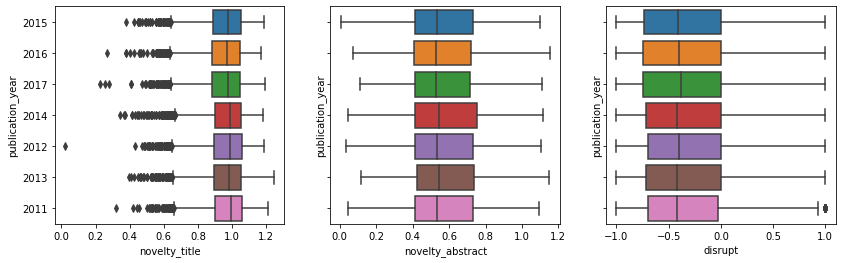

hi journal_name novelty_title
hi journal_name novelty_abstract
hi journal_name disrupt


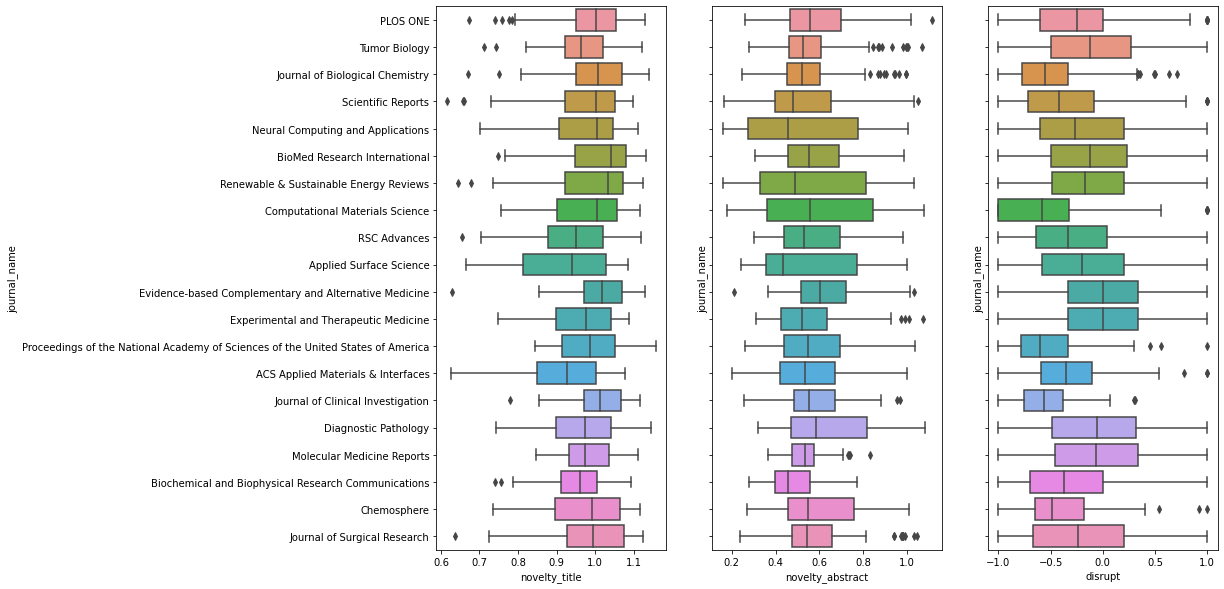

hi concept0 novelty_title
hi concept0 novelty_abstract
hi concept0 disrupt


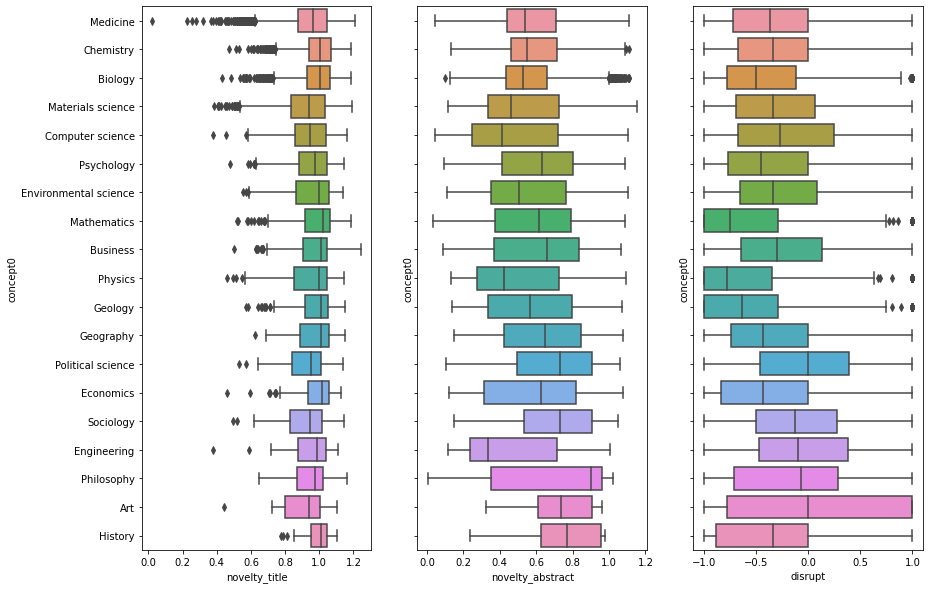

hi concept1 novelty_title
hi concept1 novelty_abstract
hi concept1 disrupt


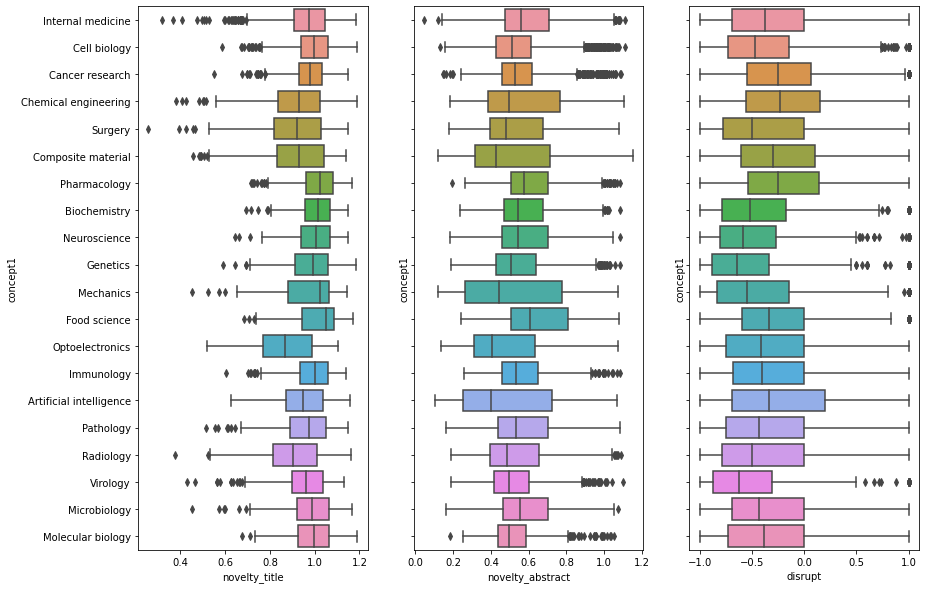

In [31]:

for var, figsize in [
        ('publication_year', (14, 4)),
        ('journal_name', (14, 10)),
        ('concept0', (14, 10)),
        ('concept1', (14, 10)),
    ]:
    f, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
    top_groups = df.groupby(var)[var].count().nlargest(20).index
    data = df[df[var].isin(top_groups)].copy()
    data[var] = data[var].astype('category')
    data[var] = data[var].cat.set_categories(list(top_groups))
    data = data.sort_values([var])
    for i, outcome in enumerate(['novelty_title', 'novelty_abstract', 'disrupt']):
        print('hi', var, outcome)
        sns.boxplot(data=data, y=var, x=outcome, ax=axes[i])
    plt.show()
        # ax.set(xlim=(-1,1))

<AxesSubplot:xlabel='disrupt', ylabel='publication_year'>

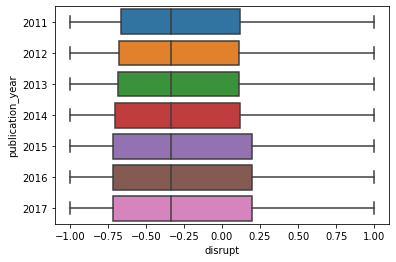

In [34]:

sns.boxplot(data=analysis_df, y='publication_year', x='disrupt', orient='h')

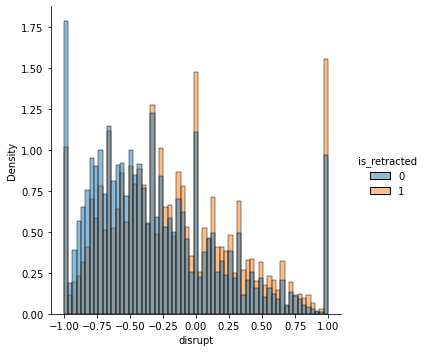

In [37]:
# f, ax = plt.subplots(figsize=(8, 4))
df = analysis_df[(analysis_df.len_I + analysis_df.len_J) > 5]
sns.displot(data=df, x='disrupt', hue='is_retracted', stat='density', common_norm=False)
# ax.set(xlim=(-1,1))

[(-1.0, 1.0)]

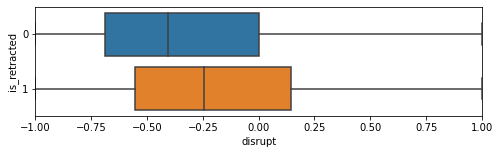

In [43]:
df = analysis_df[(analysis_df.len_I + analysis_df.len_J) > 5]
f, ax = plt.subplots(figsize=(8, 2))
sns.boxplot(data=df, y='is_retracted', x='disrupt', orient='h')
ax.set(xlim=(-1,1))

[(-1.0, 1.0)]

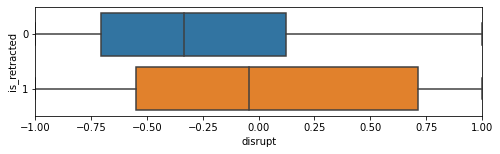

In [39]:
f, ax = plt.subplots(figsize=(8, 2))
sns.boxplot(data=analysis_df, y='is_retracted', x='disrupt', orient='h')
ax.set(xlim=(-1,1))

[(-1.0, 1.0)]

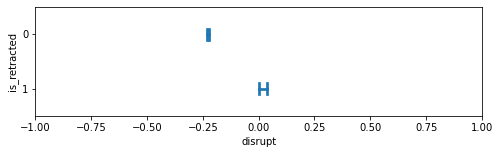

In [40]:
f, ax = plt.subplots(figsize=(8, 2))
sns.pointplot(data=analysis_df, y='is_retracted', x='disrupt', orient='h', ci=95, join=False, capsize=.2, markers='')
ax.set(xlim=(-1,1))

In [44]:
df = analysis_df[(analysis_df.len_I + analysis_df.len_J) > 5]
retracted =   df[(df['is_retracted'] == True)  & df['disrupt'].notna() ]
unretracted = df[(df['is_retracted'] == False) & df['disrupt'].notna() ]
print('n =', len(retracted)+len(unretracted))
sp.ttest_ind(retracted['disrupt'], unretracted['disrupt'])

n = 69629


Ttest_indResult(statistic=18.193167716802908, pvalue=8.673525359744594e-74)

In [45]:
analysis_df[['disrupt', 'focal_refs']].dropna().corr()

,disrupt,focal_refs
disrupt,1.000000,-0.294661
focal_refs,-0.294661,1.000000


<AxesSubplot:xlabel='n_citing', ylabel='Count'>

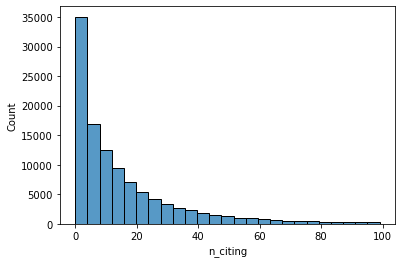

In [46]:
count_cites = analysis_df[(analysis_df.len_I + analysis_df.len_J) < 100].copy()
count_cites['n_citing'] = (analysis_df.len_I + analysis_df.len_J)
sns.histplot(data=count_cites, x='n_citing', bins=25)